### 超平面划分
如果两个数据集在空间中是两个凸集,那么它们可以用一个超平面来实现线性分割. 因此机器学习的最基础分类问题就是学习一个超平面, 来解决凸集划分问题.   
如果我们令x为m维行向量，表征m维空间中的任意一点;令w为m维列向量，b为常数偏置。m维超平面的表达式可以写成$xw+b = 0$, 很直观的, 对给定的w, 满足条件的x是在m维空间中的一个m-1维横切面.这个w就是超平面的法向量. 因为是法向量, 所以w的范数和超平面的形状没有关系, 即w乘以一个常数c, 超平面不发生变化.  
我们会用到的一个参数是"空间中任意一点$x$到超平面的欧氏距离.这个距离的推导如下, 首先我们在超平面上找任意一点$x_0 w+b = 0$, $-x_0 w = b$, 连接它和x形成向量$x-x_0$, 距离d等于向量在超平面法向量方向,即w的方向上的投影.也就是
$$ d = \frac{(x-x_0)w}{||w||} = \frac{ xw-x_0 w}{||w||} = \frac{xw+b}{||w||} $$
使用超平面二分类样本时, 我们会计算$xw+b$的数值, 如果大于0就是正样本, 小于0就是负样本.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

np.random.seed(2020)

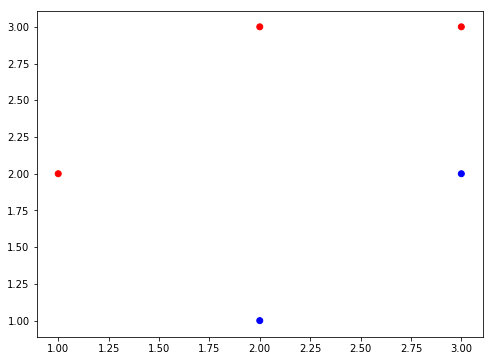

In [2]:
X = np.array([[1,2],[2,3],[3,3],[2,1],[3,2]])
y = np.array([[1],[1],[1],[-1],[-1]])

clist=['blue','red']

plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],c = y.flatten(),cmap = ListedColormap(clist))

In [3]:
def lin_func(x,w,b):
    return x.dot(w)+b

def train(loss_func,lr):
    w = np.zeros((2,1))
    b = 0.
    for t in range(1000):
        loss,dw,db = loss_func(X,y,w,b)
        w -= lr*dw
        b -= lr*db
        if (t+1)%100==0:
            print("loss: {:.4f}".format(loss.item()))
    return w,b
        
def Show(w,b):
    xx = np.linspace(0,4)
    slope = (-w[0]/(w[1]+1e-5))
    bias = (-b/(w[1]+1e-5))

    yy = slope*xx+bias
    plt.figure(figsize=(8,6))
    plt.axis([0,4,0,4])
    plt.plot(xx,yy, c = 'black')
    plt.scatter(X[:,0],X[:,1],c = y.flatten(),cmap = ListedColormap(clist))
    plt.show()

### Perceptron
感知机的思想是, 我们首先初始化一个超平面, 如果发现有某些样本是错分的, 就把超平面向反方向移动一点. 这样反复多次就能找到能尽可能正确分类的平面了.显然错分程度越大，则移动的步长也应该越大。如果让错分程度和损失函数大小呈线性关系，则有下面的损失函数。
$$ \hat y = xw+b $$
$$ loss(\hat y,y) = max(-\hat y\cdot y,0) $$
损失越小，错分程度越小，损失为0时将没有样本被错分。使用梯度方法优化这个函数就可以训练感知机超平面。

Text(0.5,1,'y==1')

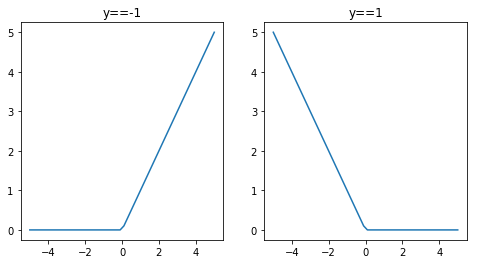

In [4]:
x_axis = np.linspace(-5,5,50)
y_loss_0 = np.clip(x_axis,0,np.inf)
y_loss_1 = np.clip(-x_axis,0,np.inf)

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(x_axis,y_loss_0)
ax[0].set_title('y==-1')
ax[1].plot(x_axis,y_loss_1)
ax[1].set_title('y==1')

loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000


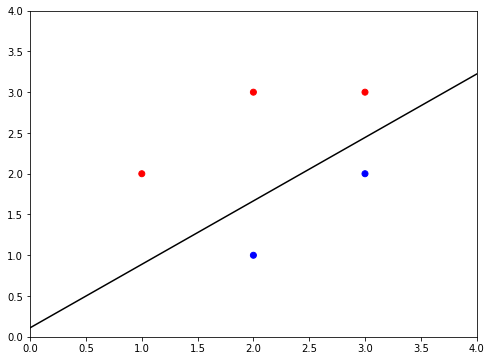

In [5]:
def perceptron_loss(x,y,w,b):
    y_hat = lin_func(x,w,b)
    margin = -y*y_hat
    zeros_mask = margin<0
    margin[zeros_mask] = 0
    loss = np.mean(margin,axis = 0)
    
    y_masked = y.copy()
    y_masked[zeros_mask] = 0
    dw = x.T.dot(-y_masked)
    db = np.sum(-y_masked,axis = 0)
    
    return loss,dw,db



w,b = train(perceptron_loss,0.02)
Show(w,b)

### SVM
在SVM中,我们想从两类样本之间确定一个最好的超平面,这个超平面满足的性质是到两类样本的最小距离最大.很自然的, 我们可以看出这个超平面到两类样本的最小距离应该相等. 设到超平面最近的两个样本是$x^+$和$x^-$, 样本距离$d=\frac{xw+b}{||w||}$, 也就是$x^-w+b =  -(x^+w+b) = C $. 我们不妨让C = 1, 即两个样本$x^+$和$x^-$会分别落在$xw+b = 1$和$xw+b = -1$超平面上. 其他样本都在这两个超平面以外.  
根据上面的一系列假设, 任何正样本不应该大过$xw+b = 1$，任何负样本不应该小过$xw+b = -1$。我们的损失函数就应该是: 
$$ loss(\hat y,y) = max(1-\hat y\cdot y,0) $$
到此还不算结束, 因为我们还想要这个最小距离最大化. 我们知道$d=\frac{xw+b}{||w||}$, 而$|x^+w+b| =  |x^-w+b| = 1 $, 即$d=\frac{1}{||w||}$, 也就是最大化距离, 只需要最小化w即可. 最小化一个参数常用的做法是正则化, 也就是对w施加L2的惩罚(L1的惩罚性质较差, 容易让w为0).这样我们就得到了最大化最小距离的损失. 
$$ loss(w)=\frac{1}{2}||w||_2 $$
我们把上面两个损失函数加起来, 并给正则化项乘上一个常数系数, 用来调控(正确分类) vs (最大化间隔)两个目标的重要程度. 优化该损失函数就能得到最大间隔的线性SVM。
$$ \hat y = xw+b $$
$$ loss(w,\hat y,y) = max(1-\hat y\cdot y,0)+\lambda\frac 1 2 ||w||^2 $$

Text(0.5,1,'y==1')

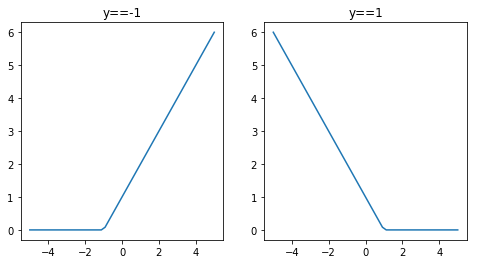

In [6]:
x_axis = np.linspace(-5,5,50)
y_loss_0 = np.clip(1+x_axis,0,np.inf)
y_loss_1 = np.clip(1-x_axis,0,np.inf)

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(x_axis,y_loss_0)
ax[0].set_title('y==-1')
ax[1].plot(x_axis,y_loss_1)
ax[1].set_title('y==1')

loss: 0.2710
loss: 0.5569
loss: 0.2881
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000
loss: 0.0000


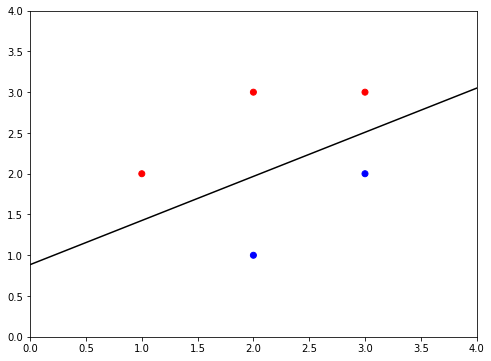

In [7]:
def svm_loss(x,y,w,b,lamda=0.2):
    y_hat = lin_func(x,w,b)
    margin = 1-y*y_hat
    zeros_mask = margin<0
    margin[zeros_mask] = 0
    loss = np.mean(margin,axis = 0)
    
    y_masked = y.copy()
    y_masked[zeros_mask] = 0
    dw = x.T.dot(-y_masked)+lamda*w
    db = np.sum(-y_masked,axis = 0)
    
    return loss,dw,db


w,b = train(svm_loss, 0.1)
Show(w,b)

### Logitsic Regression
逻辑回归和感知机类似,都是超平面划分的线性模型. 一个不同点是, 逻辑回归返回的不是分类类别, 而是分类为正样本的概率.
$$ p = \frac{1}{1+exp(-(xw+b))} $$
计算概率p使用的激活函数是sigmoid,可以把任意大小的输入o变换到0-1区间, 也就是一个概率. 而概率模型我们知道, 可以用对数似然损失来优化.模型计算正样本的概率是p, 负样本的概率是(1-p).  
$$ loss(p) = -log(p)=log(1+exp(-(xw+b)) \qquad (y=1)$$
$$ loss(p) = -log(1-p)=log(1+exp(xw+b)) \qquad (y=-1)$$
也就是标签为正样本时,使用p计算负对数似然, 负样本时使用(1-p)计算. 优化这个目标函数就能让算法收敛到一个让似然最大的超平面. 稍微改写一下损失函数就得到
$$ \hat y = xw+b $$
$$ loss(\hat y,y) = log(1+exp(-y\cdot \hat y)) $$

Text(0.5,1,'y==1')

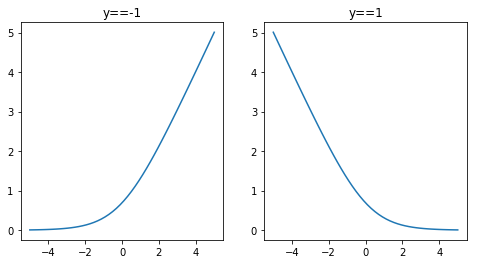

In [8]:
x_axis = np.linspace(-5,5,50)
y_loss_0 = np.log(1+np.exp(x_axis))
y_loss_1 = np.log(1+np.exp(-x_axis))

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(x_axis,y_loss_0)
ax[0].set_title('y==-1')
ax[1].plot(x_axis,y_loss_1)
ax[1].set_title('y==1')

loss: 0.0853
loss: 0.0475
loss: 0.0333
loss: 0.0258
loss: 0.0211
loss: 0.0179
loss: 0.0155
loss: 0.0137
loss: 0.0123
loss: 0.0111


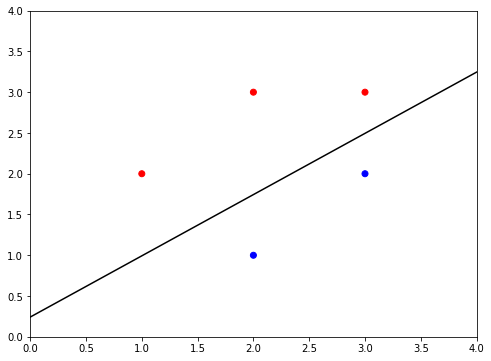

In [9]:
def logistic_loss(x,y,w,b):
    y_hat = lin_func(x,w,b)
    
    loss = np.mean(np.log(1+np.exp(-y*y_hat)),axis=0)
    
    dy = (-y*np.exp(-y*y_hat))/(1+np.exp(-y*y_hat))
    dw = x.T.dot(dy)
    db = np.sum(dy,axis=0)
    
    return loss,dw,db

w,b = train(logistic_loss, 0.1)
Show(w,b)